# Perceval Quest
#### Author: *Valentin Deumier*

Our goal is to start by creating a 'classical' neural network and train it on the famous MNIST handwritten digits dataset, and then try to upgrade it by using Linear Optical Quantum Computing, in hope to increase the accuracy of the model and lower the duration of the calculations.

### <u>2: A hybrid model</u>

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from tqdm import tqdm
import os
os.environ["OMP_NUM_THREADS"] = "12"
print(np.__version__)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model

import perceval as pcvl
import perceval.components as comp
from perceval.rendering.circuit import SymbSkin, PhysSkin
from perceval import Circuit

# Parameters
IMG_SIZE = 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 30

1.24.3


2025-01-12 20:25:34.804581: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-12 20:25:35.181030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 20:25:36.336784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/deumier/Documents/LOQC_MNIST/.venv/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
# Data into numpy arrays
def load_data(filename):

    data = pd.read_csv(filename)
    X = np.array(data['image'].str.split(',', expand=True).values)

    # Remove the [ ] from the image data (fastest method I found)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X[i, j] = X[i, j].replace('[', '').replace(']', '')
    X = X.astype(float)

    y = data['label'].values

    X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)/255.0      # Reshape and normalize
    y = to_categorical(y, NUM_CLASSES)
    return X, y

# Get the absolute path to the data folder
script_dir = os.getcwd()
data_dir = os.path.join(script_dir, 'data')

# Load the data
train_file = os.path.join(data_dir, 'train.csv')
X_train, y_train = load_data(train_file)
val_file = os.path.join(data_dir, 'val.csv')
X_val, y_val = load_data(val_file)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# Divide the image resolution by 4 using max pooling and avg pooling
X_train = np.array(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X_train))/255.0
X_val = np.array(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(X_val))/255.0

X_train = np.array(tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(X_train))
X_val = np.array(tf.keras.layers.AveragePooling2D(pool_size=(2, 2))(X_val))

# This step is necessary as the number of modes needed for the circuit is IMG_SIZE, 
# and I found that seven modes is a maximum that I can do before the calculation takes too long
# It could be improved with better computing ressources

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(6000, 28, 28, 1) (6000, 10) (600, 28, 28, 1) (600, 10)
(6000, 7, 7, 1) (6000, 10) (600, 7, 7, 1) (600, 10)


2025-01-12 20:25:41.612239: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31044 MB memory:  -> device: 0, name: Quadro GV100, pci bus id: 0000:d5:00.0, compute capability: 7.0
2025-01-12 20:25:42.030120: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


The idea here is to encode the image data into quantum data while preserving the 2-dimensional structure of the image. \
\
Like in the CNN model, we want neighbours pixels to remain close to each other in the quantum representation so that we can perform "local" transformation (the equivalent of convoluting the image with a kernel), so the representation has to be continuous along both axis.\
This means that we can't flatten the data, so we can't use basis, angle or amplitude embedding.\
\
An idea could be to encode the image in a matrix representation of a unitary transformation (that could also be parametrized, and have its parameters be optimized).\
\
Being inspired by the solution of Schrodinger's equation for a time-independant Hamiltonian, we are going to represent the image $\mathbf{x}$ as the resulting evolution operator :

$$ U_t(\mathbf{x}) = \exp(-iH_{\mathbf{x}}t) $$

Where $H_{\mathbf{x}}$ is the symetric part of our image matrix (so that $U_t(\mathbf{x})$ is unitary):

$$ H_{\mathbf{x}} = \frac{\mathbf{x} + \mathbf{x}^T}{2} $$

with $t \in \mathbb{R}$ a parameter that we can tweak.

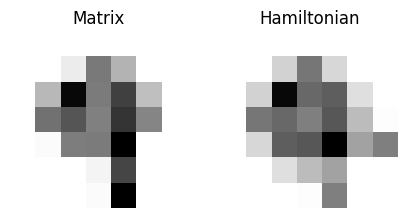

In [3]:
def toHamiltonian(x):
    H = 0.5*(x[:, :, 0] + x[:, :, 0].T)
    return H

def plot_hamiltonian(x):
    L = [x, toHamiltonian(x)]
    labels = ['Matrix', 'Hamiltonian']
    fig, axes = plt.subplots(1, 2, figsize=(5, 5))
    for i in range(2):
        axes[i].imshow(L[i], cmap='gray_r')
        axes[i].set_title(labels[i])
        axes[i].axis('off')
    plt.show()

# Plot the first image and its Hamiltonian
plot_hamiltonian(X_train[1])

In [4]:
# As an example, we are computing the operator associated with the second image

def U(x: np.ndarray, t: float) -> np.ndarray:
    """Compute the unitary operator associated with the Hamiltonian x and time t"""
    H = toHamiltonian(x)
    return linalg.expm(-1j*H*t)

# M = pcvl.Matrix(U(X_train[1], 1000))
# c1 = comp.Unitary(U=M)

# Decompose the unitary into a circuit
# ub = pcvl.Circuit(2, name="ub") // comp.BS() // (0, comp.PS(phi=pcvl.Parameter("φ_a"))) // comp.BS() // (1, comp.PS(phi=pcvl.Parameter("φ_b")))
# c2 = pcvl.Circuit.decomposition(M, ub, shape=pcvl.InterferometerShape.TRIANGLE)
# pcvl.pdisplay(c2)

To reproduce the local effect of the convolution, the next layer will be constituted of a brickwork layout of beam splitters that are acting on modes close to each other.\
\
The operator associated with this layer will be denoted $V(\mathbf{\omega})$, with $\mathbf{\omega}$ being the array of parameters of the beam splitters.

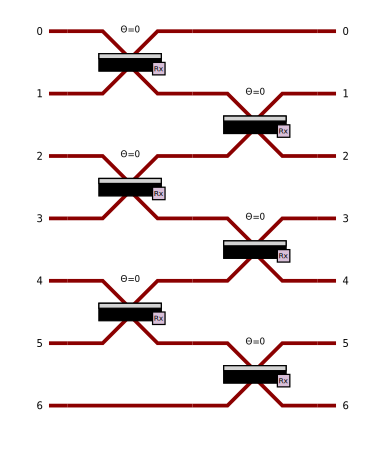

In [5]:
def brickwork(
    omega: np.ndarray,
    num_modes: int,
) -> Circuit:
    """
    Create a brickwork circuit with BS components.
    Args:   
        omega         : BS parameters (len(omega) = num_modes - 1)
        num_modes : Width of circuit
    Returns:
        Circuit
    """
    circ = Circuit(num_modes)
    even_modes = np.arange(0, num_modes - 1, 2)
    odd_modes = np.arange(1, num_modes - 1, 2)

    for k in even_modes:
        circ.add(int(k), comp.BS(omega[int(k)]))
    for j in odd_modes:
        circ.add(int(j), comp.BS(omega[int(j)]))
   
    return circ

# Example of a V(omega) layer
omega = np.zeros(6)
c2 = brickwork(omega, 7)
pcvl.pdisplay(c2)

# To do: Check if the model is better if we add phase shifters to the V layer

In [6]:
N = 7      # Number of photons
m = 7      # Number of modes   
L = 5       # Number of layers

# Input state with N photons and m modes
input_state = pcvl.BasicState([1]*N+[0]*(m-N))
print(input_state)

# Random parameters for the circuit initialization
t_params = np.random.uniform(0, 100, L)
omega_params = np.random.uniform(0, 2*np.pi, L*(m-1))

|1,1,1,1,1,1,1>


The code will follow the following scheme:
- Use the fonction **create_circuit(x, params)** that create the circuit with L layers $U_t(\mathbf{x}) V(\mathbf{\omega})$ associated to the image $\mathbf{x}$.
- Compute the full output probability with the input $N*|1>$.
- Convert the output into a predicted label
- Compute the sparse categorical cross-entropy loss (that is a function of $\mathbf{x}$ and the parameters)
- Do a minimization step.

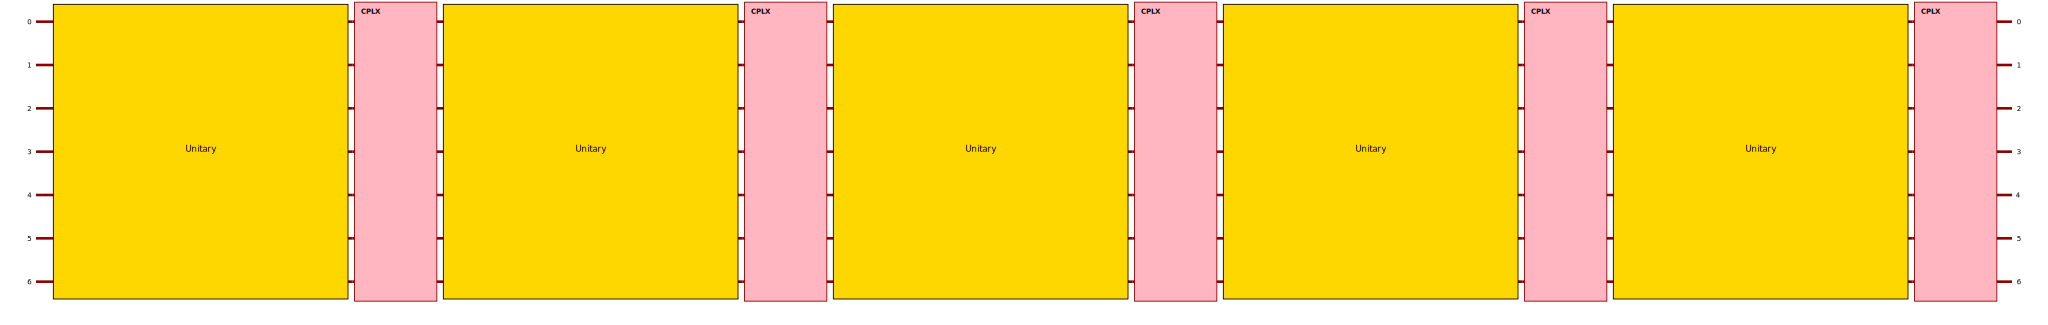

In [7]:
def create_circuit(x, t_params, omega_params):
    c = Circuit(m)
    for i in range(L):
        c.add(0, comp.Unitary(U=pcvl.Matrix(U(x, t_params[i]))))
        c.add(0, brickwork(omega_params[i*(m-1):(i+1)*(m-1)], m))
    return c

c = create_circuit(X_train[1], t_params, omega_params)
pcvl.pdisplay(c)

In [8]:
def compute_probabilities(x, t_params, omega_params):
    processor = pcvl.Processor("SLOS", create_circuit(x, t_params, omega_params))
    processor.with_input(input_state)
    sampler = pcvl.algorithm.Sampler(processor)
    prob_dist = sampler.probs()
    return prob_dist

# processor = pcvl.Processor("SLOS", create_circuit(X_train[2], t_params, omega_params))
# processor.with_input(input_state)

# sampler = pcvl.algorithm.Sampler(processor)
# prob_dist = sampler.probs()

# argmax = np.argmax(list(prob_dist['results'].values()))
# most_probable_output = list(prob_dist['results'].keys())[argmax]
# most_probable_probability = list(prob_dist['results'].values())[argmax]

# print("The most probable output is", most_probable_output, "with probability", most_probable_probability)

To convert the output state of the circuit into a predicted label, my intuition is to think of the output state as a spatial distribution of guesses:
* The more there are photons close to the top mode, the more the predicted label is close to 0
* The more there are photons close to the bottom mode, the more the predicted label is close to 9

I have decided to take the exponential of this spatial distribution, so that the output is less biased towards middle values like 4 or 5.

In [9]:
# Convert from the repartition of photon in the most probable output to a label
def output_to_label(output):
    return int(np.round(np.average(range(len(output)), weights=np.exp(output))*3/2))       # Scale the output to the range [0, 9]

def confidence_array(prob_dist):
    confidence = np.zeros(NUM_CLASSES)
    for output, prob in prob_dist['results'].items():
        label = output_to_label(output)
        confidence[label] += prob
    return confidence

# print(output_to_label(most_probable_output))

In [10]:
def sparse_categorical_crossentropy(y_true, y_pred):
    return -np.log(y_pred[y_true])

def sparse_categorical_accuracy(y_true, y_pred):
    return np.argmax(y_pred) == y_true

def model_accuracy(X, y, t_params, omega_params):
    accuracy = 0
    for i in range(X.shape[0]):
        prob_dist = compute_probabilities(X[i], t_params, omega_params)
        confidence = confidence_array(prob_dist)
        y_pred = np.argmax(confidence)
        y_true = np.argmax(y[i])
        accuracy += sparse_categorical_accuracy(y_true, confidence)
    return accuracy/X.shape[0]


In [11]:
def minimize_step(x, y_true, t_params, omega_params, learning_rate=0.01):
    # Compute the probabilities
    prob_dist = compute_probabilities(x, t_params, omega_params)
    y_pred = confidence_array(prob_dist)
    
    # Compute the loss
    loss = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
    
    # Compute the gradients (numerical gradient approximation)
    grad_t_params = np.zeros_like(t_params)
    grad_omega_params = np.zeros_like(omega_params)
    
    epsilon = 1e-5
    for i in range(len(t_params)):
        t_params[i] += epsilon
        prob_dist = compute_probabilities(x, t_params, omega_params)
        y_pred = confidence_array(prob_dist)
        loss_plus = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
        
        grad_t_params[i] = (loss_plus - loss) / epsilon
        t_params[i] -= epsilon
    
    for i in range(len(omega_params)):
        omega_params[i] += epsilon
        prob_dist = compute_probabilities(x, t_params, omega_params)
        y_pred = confidence_array(prob_dist)
        loss_plus = sparse_categorical_crossentropy(np.argmax(y_true), y_pred)
        
        grad_omega_params[i] = (loss_plus - loss) / epsilon
        omega_params[i] -= epsilon
    
    # Update the parameters
    t_params -= learning_rate * grad_t_params
    omega_params -= learning_rate * grad_omega_params
    
    return t_params, omega_params, loss

# Example usage
x = X_train[0]
y_true = y_train[0]
t_params, omega_params, loss = minimize_step(x, y_true, t_params, omega_params)
print("Updated t_params:", t_params)
print("Updated omega_params:", omega_params)
print("Loss:", loss)

Updated t_params: [22.4645087  38.89372966  5.9516905  77.61224661 89.47123115]
Updated omega_params: [1.57441733 2.88419773 1.79775743 3.84129175 0.92331513 4.91989834
 2.05345212 1.58244568 2.20149672 4.38805281 3.03239695 4.71099771
 1.05999601 5.94605615 3.82365152 4.96997405 2.20386803 0.48435384
 5.65742015 0.99838407 5.11224968 5.78149738 0.49654352 3.33613574
 2.68006475 3.0081811  3.50231695 4.66954767 5.74781695 1.33384013]
Loss: 1.8509940980650257


Epoch 0


Training:   0%|          | 1/6000 [00:03<6:05:26,  3.65s/it]

Loss: 1.916200652694854


Training:   0%|          | 11/6000 [00:40<6:03:26,  3.64s/it]

Loss: 1.7908165284930582


Training:   0%|          | 21/6000 [01:16<6:02:11,  3.63s/it]

Loss: 2.313439024023561


Training:   1%|          | 31/6000 [01:53<6:02:42,  3.65s/it]

Loss: 3.1928296218007506


Training:   1%|          | 41/6000 [02:29<6:01:30,  3.64s/it]

Loss: 2.3128966580546235


Training:   1%|          | 51/6000 [03:06<6:01:17,  3.64s/it]

Loss: 3.8518615887677954


Training:   1%|          | 61/6000 [03:42<6:01:12,  3.65s/it]

Loss: 1.5608090912318329


Training:   1%|          | 71/6000 [04:18<6:00:49,  3.65s/it]

Loss: 1.8040051113106983


Training:   1%|▏         | 81/6000 [04:55<5:54:53,  3.60s/it]

Loss: 1.9157252134775606


Training:   2%|▏         | 91/6000 [05:30<5:52:00,  3.57s/it]

Loss: 3.8400711618773355


Training:   2%|▏         | 101/6000 [06:07<6:00:35,  3.67s/it]

Loss: 1.5612286094555046


Training:   2%|▏         | 111/6000 [06:42<5:50:52,  3.57s/it]

Loss: 2.3178769134217805


Training:   2%|▏         | 121/6000 [07:18<5:49:28,  3.57s/it]

Loss: 3.200172790339921


Training:   2%|▏         | 131/6000 [07:54<5:50:36,  3.58s/it]

Loss: 1.8049063206203377


Training:   2%|▏         | 141/6000 [08:30<5:48:10,  3.57s/it]

Loss: 2.3329378060012234


Training:   3%|▎         | 151/6000 [09:05<5:48:00,  3.57s/it]

Loss: 2.336064750635539


Training:   3%|▎         | 161/6000 [09:41<5:47:29,  3.57s/it]

Loss: 2.3176693805757056


Training:   3%|▎         | 171/6000 [10:17<5:46:20,  3.57s/it]

Loss: 3.8503729729686165


Training:   3%|▎         | 181/6000 [10:52<5:46:36,  3.57s/it]

Loss: 3.1899967576316124


Training:   3%|▎         | 191/6000 [11:28<5:45:48,  3.57s/it]

Loss: 1.5712615527302018


Training:   3%|▎         | 201/6000 [12:04<5:47:21,  3.59s/it]

Loss: 3.1808437452350096


Training:   4%|▎         | 211/6000 [12:40<5:44:10,  3.57s/it]

Loss: 3.8555440595702164


Training:   4%|▎         | 221/6000 [13:16<5:45:33,  3.59s/it]

Loss: 1.7987446691243405


Training:   4%|▍         | 231/6000 [13:52<5:46:22,  3.60s/it]

Loss: 3.850844872321406


Training:   4%|▍         | 241/6000 [14:28<5:44:35,  3.59s/it]

Loss: 2.3466591570860937


Training:   4%|▍         | 251/6000 [15:04<5:44:42,  3.60s/it]

Loss: 3.4208423142155384


Training:   4%|▍         | 261/6000 [15:40<5:43:29,  3.59s/it]

Loss: 1.9045751177505292


Training:   5%|▍         | 271/6000 [16:16<5:42:42,  3.59s/it]

Loss: 2.3460955388361318


Training:   5%|▍         | 281/6000 [16:51<5:41:19,  3.58s/it]

Loss: 3.8309477710925046


Training:   5%|▍         | 291/6000 [17:27<5:40:10,  3.58s/it]

Loss: 1.5718406207489015


Training:   5%|▌         | 301/6000 [18:03<5:41:11,  3.59s/it]

Loss: 1.7828748032577406


Training:   5%|▌         | 311/6000 [18:39<5:39:35,  3.58s/it]

Loss: 2.3381139708038017


Training:   5%|▌         | 321/6000 [19:15<5:39:50,  3.59s/it]

Loss: 3.199207882173648


Training:   6%|▌         | 331/6000 [19:51<5:38:56,  3.59s/it]

Loss: 3.843667416535875


Training:   6%|▌         | 341/6000 [20:27<5:36:56,  3.57s/it]

Loss: 1.5757089501306663


Training:   6%|▌         | 351/6000 [21:03<5:37:09,  3.58s/it]

Loss: 1.7748310240569525


Training:   6%|▌         | 361/6000 [21:38<5:36:46,  3.58s/it]

Loss: 3.2054833012765807


Training:   6%|▌         | 371/6000 [22:14<5:35:49,  3.58s/it]

Loss: 1.7720106686243375


Training:   6%|▋         | 381/6000 [22:50<5:40:33,  3.64s/it]

Loss: 1.8039697753233357


Training:   7%|▋         | 391/6000 [23:27<5:41:17,  3.65s/it]

Loss: 3.186974907879861


Training:   7%|▋         | 401/6000 [24:04<5:39:56,  3.64s/it]

Loss: 2.339528851328856


Training:   7%|▋         | 411/6000 [24:40<5:39:05,  3.64s/it]

Loss: 3.4265815166149665


Training:   7%|▋         | 421/6000 [25:16<5:38:41,  3.64s/it]

Loss: 3.425767012678652


Training:   7%|▋         | 431/6000 [25:53<5:38:17,  3.64s/it]

Loss: 2.333237392740922


Training:   7%|▋         | 441/6000 [26:29<5:37:20,  3.64s/it]

Loss: 3.8268150611054472


Training:   8%|▊         | 451/6000 [27:06<5:37:18,  3.65s/it]

Loss: 2.3376897788100672


Training:   8%|▊         | 461/6000 [27:42<5:36:28,  3.64s/it]

Loss: 3.4035425690823837


Training:   8%|▊         | 471/6000 [28:19<5:35:51,  3.64s/it]

Loss: 3.39662557684648


Training:   8%|▊         | 481/6000 [28:55<5:35:17,  3.65s/it]

Loss: 1.7751448129962215


Training:   8%|▊         | 491/6000 [29:32<5:39:29,  3.70s/it]

Loss: 3.8372842006668044


Training:   8%|▊         | 501/6000 [30:08<5:29:46,  3.60s/it]

Loss: 3.828872944622425


Training:   9%|▊         | 511/6000 [30:44<5:28:50,  3.59s/it]

Loss: 1.58328949750262


Training:   9%|▊         | 521/6000 [31:20<5:28:16,  3.59s/it]

Loss: 3.2118818895134242


Training:   9%|▉         | 531/6000 [31:56<5:28:02,  3.60s/it]

Loss: 1.7698339057625083


Training:   9%|▉         | 541/6000 [32:32<5:26:23,  3.59s/it]

Loss: 1.5907946577284915


Training:   9%|▉         | 551/6000 [33:08<5:29:39,  3.63s/it]

Loss: 2.3124588210803303


Training:   9%|▉         | 561/6000 [33:44<5:28:10,  3.62s/it]

Loss: 1.8018587783611046


Training:  10%|▉         | 571/6000 [34:20<5:29:58,  3.65s/it]

Loss: 2.34413605884971


Training:  10%|▉         | 581/6000 [34:57<5:29:47,  3.65s/it]

Loss: 3.841226130290712


Training:  10%|▉         | 591/6000 [35:34<5:30:39,  3.67s/it]

Loss: 3.3799526272982323


Training:  10%|█         | 601/6000 [36:10<5:27:30,  3.64s/it]

Loss: 1.7984694838657507


Training:  10%|█         | 611/6000 [36:47<5:27:06,  3.64s/it]

Loss: 3.372344039105307


Training:  10%|█         | 621/6000 [37:23<5:26:32,  3.64s/it]

Loss: 3.370159732861636


Training:  11%|█         | 631/6000 [37:59<5:25:56,  3.64s/it]

Loss: 3.8441262523495037


Training:  11%|█         | 641/6000 [38:36<5:25:34,  3.65s/it]

Loss: 1.599309759966905


Training:  11%|█         | 651/6000 [39:12<5:24:26,  3.64s/it]

Loss: 1.9187304860887502


Training:  11%|█         | 661/6000 [39:49<5:24:35,  3.65s/it]

Loss: 1.7535697348906634


Training:  11%|█         | 671/6000 [40:25<5:24:05,  3.65s/it]

Loss: 2.3231299914514727


Training:  11%|█▏        | 681/6000 [41:02<5:23:29,  3.65s/it]

Loss: 2.3221048337376096


Training:  12%|█▏        | 691/6000 [41:38<5:22:40,  3.65s/it]

Loss: 1.9204226281744519


Training:  12%|█▏        | 701/6000 [42:15<5:21:21,  3.64s/it]

Loss: 3.3728426836606067


Training:  12%|█▏        | 711/6000 [42:51<5:20:44,  3.64s/it]

Loss: 1.9168822150795295


Training:  12%|█▏        | 721/6000 [43:28<5:20:16,  3.64s/it]

Loss: 1.7388789159615614


Training:  12%|█▏        | 731/6000 [44:04<5:19:32,  3.64s/it]

Loss: 3.176694773558352


Training:  12%|█▏        | 741/6000 [44:40<5:19:09,  3.64s/it]

Loss: 1.7339728359883444


Training:  13%|█▎        | 751/6000 [45:17<5:18:43,  3.64s/it]

Loss: 1.8977068249495757


Training:  13%|█▎        | 761/6000 [45:53<5:18:26,  3.65s/it]

Loss: 3.1341723504998384


Training:  13%|█▎        | 771/6000 [46:30<5:17:19,  3.64s/it]

Loss: 1.8190045380084112


Training:  13%|█▎        | 781/6000 [47:07<5:26:35,  3.75s/it]

Loss: 3.348334353637088


Training:  13%|█▎        | 791/6000 [47:43<5:16:14,  3.64s/it]

Loss: 1.81477927373696


Training:  13%|█▎        | 801/6000 [48:19<5:15:20,  3.64s/it]

Loss: 2.359756327281641


Training:  14%|█▎        | 811/6000 [48:56<5:14:56,  3.64s/it]

Loss: 2.354372260016692


Training:  14%|█▎        | 821/6000 [49:32<5:14:14,  3.64s/it]

Loss: 2.337166449596145


Training:  14%|█▍        | 831/6000 [50:09<5:13:57,  3.64s/it]

Loss: 1.7396895387009186


Training:  14%|█▍        | 841/6000 [50:45<5:13:12,  3.64s/it]

Loss: 1.7382959879998359


Training:  14%|█▍        | 851/6000 [51:22<5:12:52,  3.65s/it]

Loss: 3.8262043789806968


Training:  14%|█▍        | 861/6000 [51:58<5:12:48,  3.65s/it]

Loss: 2.3621738388773488


Training:  15%|█▍        | 871/6000 [52:35<5:12:01,  3.65s/it]

Loss: 2.337009691205032


Training:  15%|█▍        | 881/6000 [53:11<5:13:58,  3.68s/it]

Loss: 2.3562127247038656


Training:  15%|█▍        | 891/6000 [53:48<5:09:43,  3.64s/it]

Loss: 3.3335112401994667


Training:  15%|█▌        | 901/6000 [54:24<5:08:58,  3.64s/it]

Loss: 1.8947734900061115


Training:  15%|█▌        | 911/6000 [55:01<5:08:36,  3.64s/it]

Loss: 3.8521170840477303


Training:  15%|█▌        | 921/6000 [55:37<5:07:52,  3.64s/it]

Loss: 3.1777179405584883


Training:  16%|█▌        | 931/6000 [56:13<5:07:12,  3.64s/it]

Loss: 2.3502936518029225


Training:  16%|█▌        | 941/6000 [56:50<5:07:23,  3.65s/it]

Loss: 1.8161055392749321


Training:  16%|█▌        | 951/6000 [57:26<5:06:20,  3.64s/it]

Loss: 3.839231738560841


Training:  16%|█▌        | 961/6000 [58:03<5:06:09,  3.65s/it]

Loss: 3.29689969875245


Training:  16%|█▌        | 971/6000 [58:39<5:05:39,  3.65s/it]

Loss: 1.6273905362637515


Training:  16%|█▋        | 981/6000 [59:16<5:06:02,  3.66s/it]

Loss: 1.7443729707772775


Training:  17%|█▋        | 991/6000 [59:52<5:04:10,  3.64s/it]

Loss: 2.342634313792285


Training:  17%|█▋        | 1001/6000 [1:00:29<5:03:42,  3.65s/it]

Loss: 1.809987397030833


Training:  17%|█▋        | 1011/6000 [1:01:05<5:03:15,  3.65s/it]

Loss: 3.2691964271517873


Training:  17%|█▋        | 1021/6000 [1:01:41<5:02:17,  3.64s/it]

Loss: 2.349722762661666


Training:  17%|█▋        | 1031/6000 [1:02:18<5:01:51,  3.64s/it]

Loss: 3.89658847978325


Training:  17%|█▋        | 1041/6000 [1:02:54<5:01:39,  3.65s/it]

Loss: 3.8564150496160505


Training:  18%|█▊        | 1051/6000 [1:03:31<5:01:17,  3.65s/it]

Loss: 3.859747022167825


Training:  18%|█▊        | 1061/6000 [1:04:07<5:00:12,  3.65s/it]

Loss: 3.155308336305702


Training:  18%|█▊        | 1071/6000 [1:04:44<4:59:19,  3.64s/it]

Loss: 3.142620569148267


Training:  18%|█▊        | 1081/6000 [1:05:21<4:58:51,  3.65s/it]

Loss: 3.2718743153080663


Training:  18%|█▊        | 1091/6000 [1:05:57<4:57:48,  3.64s/it]

Loss: 3.246681710756895


Training:  18%|█▊        | 1101/6000 [1:06:33<4:57:12,  3.64s/it]

Loss: 3.8630538571613022


Training:  19%|█▊        | 1111/6000 [1:07:10<4:57:10,  3.65s/it]

Loss: 1.6366713314995365


Training:  19%|█▊        | 1121/6000 [1:07:46<4:56:16,  3.64s/it]

Loss: 1.8793935030735918


Training:  19%|█▉        | 1131/6000 [1:08:23<4:55:42,  3.64s/it]

Loss: 3.857872617870454


Training:  19%|█▉        | 1141/6000 [1:08:59<4:55:31,  3.65s/it]

Loss: 3.8548874594916267


Training:  19%|█▉        | 1151/6000 [1:09:36<4:54:59,  3.65s/it]

Loss: 2.349989068161948


Training:  19%|█▉        | 1161/6000 [1:10:12<4:53:50,  3.64s/it]

Loss: 3.247963288485216


Training:  20%|█▉        | 1171/6000 [1:10:49<4:59:30,  3.72s/it]

Loss: 3.2332017029163245


Training:  20%|█▉        | 1181/6000 [1:11:26<4:52:28,  3.64s/it]

Loss: 2.3530473747609464


Training:  20%|█▉        | 1191/6000 [1:12:02<4:51:56,  3.64s/it]

Loss: 3.1364204048550373


Training:  20%|██        | 1201/6000 [1:12:38<4:51:22,  3.64s/it]

Loss: 1.8765630568412601


Training:  20%|██        | 1211/6000 [1:13:15<4:50:32,  3.64s/it]

Loss: 3.928804890083494


Training:  20%|██        | 1221/6000 [1:13:51<4:50:10,  3.64s/it]

Loss: 1.6382501998142238


Training:  21%|██        | 1231/6000 [1:14:28<4:49:53,  3.65s/it]

Loss: 1.636404649464017


Training:  21%|██        | 1241/6000 [1:15:04<4:49:02,  3.64s/it]

Loss: 3.1528380296615675


Training:  21%|██        | 1251/6000 [1:15:41<4:48:28,  3.64s/it]

Loss: 2.362825351851357


Training:  21%|██        | 1261/6000 [1:16:17<4:48:03,  3.65s/it]

Loss: 2.3554825107321324


Training:  21%|██        | 1271/6000 [1:16:54<4:49:08,  3.67s/it]

Loss: 1.7993519520253596


Training:  21%|██▏       | 1281/6000 [1:17:30<4:46:20,  3.64s/it]

Loss: 3.946911818634623


Training:  22%|██▏       | 1291/6000 [1:18:07<4:44:26,  3.62s/it]

Loss: 1.7491594995532553


Training:  22%|██▏       | 1301/6000 [1:18:43<4:42:50,  3.61s/it]

Loss: 3.198538469127395


Training:  22%|██▏       | 1311/6000 [1:19:19<4:40:39,  3.59s/it]

Loss: 3.812658056899574


Training:  22%|██▏       | 1321/6000 [1:19:55<4:42:49,  3.63s/it]

Loss: 3.1518644563864573


Training:  22%|██▏       | 1331/6000 [1:20:31<4:43:28,  3.64s/it]

Loss: 1.7331441971943495


Training:  22%|██▏       | 1341/6000 [1:21:08<4:43:08,  3.65s/it]

Loss: 1.8863222738829764


Training:  23%|██▎       | 1351/6000 [1:21:44<4:42:55,  3.65s/it]

Loss: 2.3839005739680763


Training:  23%|██▎       | 1361/6000 [1:22:21<4:41:58,  3.65s/it]

Loss: 3.9849373498124883


Training:  23%|██▎       | 1371/6000 [1:22:57<4:41:44,  3.65s/it]

Loss: 1.6421402750176517


Training:  23%|██▎       | 1381/6000 [1:23:34<4:40:06,  3.64s/it]

Loss: 1.799272371981826


Training:  23%|██▎       | 1391/6000 [1:24:10<4:39:22,  3.64s/it]

Loss: 2.3850864935882403


Training:  23%|██▎       | 1401/6000 [1:24:47<4:39:09,  3.64s/it]

Loss: 2.3812888557669103


Training:  24%|██▎       | 1411/6000 [1:25:23<4:38:39,  3.64s/it]

Loss: 1.80568909399316


Training:  24%|██▎       | 1421/6000 [1:26:00<4:38:15,  3.65s/it]

Loss: 3.158144332770262


Training:  24%|██▍       | 1431/6000 [1:26:36<4:37:32,  3.64s/it]

Loss: 1.8064055883159083


Training:  24%|██▍       | 1441/6000 [1:27:12<4:37:18,  3.65s/it]

Loss: 3.9455047020309384


Training:  24%|██▍       | 1451/6000 [1:27:49<4:36:50,  3.65s/it]

Loss: 2.3436523643184834


Training:  24%|██▍       | 1461/6000 [1:28:25<4:36:10,  3.65s/it]

Loss: 3.1991203674558473


Training:  25%|██▍       | 1471/6000 [1:29:02<4:35:01,  3.64s/it]

Loss: 3.800611103204826


Training:  25%|██▍       | 1481/6000 [1:29:39<4:33:59,  3.64s/it]

Loss: 3.7958539742282964


Training:  25%|██▍       | 1491/6000 [1:30:15<4:33:20,  3.64s/it]

Loss: 3.786466141466128


Training:  25%|██▌       | 1501/6000 [1:30:51<4:33:02,  3.64s/it]

Loss: 1.6423908270668097


Training:  25%|██▌       | 1511/6000 [1:31:28<4:32:30,  3.64s/it]

Loss: 2.370889568810611


Training:  25%|██▌       | 1521/6000 [1:32:04<4:31:46,  3.64s/it]

Loss: 2.366705292856554


Training:  26%|██▌       | 1531/6000 [1:32:40<4:27:29,  3.59s/it]

Loss: 1.7920823034332805


Training:  26%|██▌       | 1541/6000 [1:33:16<4:26:44,  3.59s/it]

Loss: 3.1951376845710544


Training:  26%|██▌       | 1551/6000 [1:33:53<4:30:19,  3.65s/it]

Loss: 2.3372044817825026


Training:  26%|██▌       | 1561/6000 [1:34:29<4:33:37,  3.70s/it]

Loss: 3.208973942400708


Training:  26%|██▌       | 1571/6000 [1:35:06<4:28:48,  3.64s/it]

Loss: 3.211803065767641


Training:  26%|██▋       | 1581/6000 [1:35:42<4:28:01,  3.64s/it]

Loss: 3.2088788553424092


Training:  27%|██▋       | 1591/6000 [1:36:19<4:27:32,  3.64s/it]

Loss: 3.952609450097258


Training:  27%|██▋       | 1601/6000 [1:36:55<4:26:57,  3.64s/it]

Loss: 1.6454728494971427


Training:  27%|██▋       | 1611/6000 [1:37:32<4:26:23,  3.64s/it]

Loss: 2.3328923617615405


Training:  27%|██▋       | 1621/6000 [1:38:08<4:25:59,  3.64s/it]

Loss: 3.196618057021814


Training:  27%|██▋       | 1631/6000 [1:38:44<4:25:34,  3.65s/it]

Loss: 2.360744030728027


Training:  27%|██▋       | 1641/6000 [1:39:21<4:24:52,  3.65s/it]

Loss: 1.8873331870827055


Training:  28%|██▊       | 1651/6000 [1:39:57<4:24:34,  3.65s/it]

Loss: 1.6507051763825433


Training:  28%|██▊       | 1661/6000 [1:40:34<4:24:15,  3.65s/it]

Loss: 1.647051221465703


Training:  28%|██▊       | 1671/6000 [1:41:11<4:22:31,  3.64s/it]

Loss: 1.6457108378339083


Training:  28%|██▊       | 1681/6000 [1:41:47<4:21:52,  3.64s/it]

Loss: 2.3526105788989256


Training:  28%|██▊       | 1691/6000 [1:42:23<4:21:24,  3.64s/it]

Loss: 3.161955379829296


Training:  28%|██▊       | 1701/6000 [1:43:00<4:20:44,  3.64s/it]

Loss: 3.816620597215421


Training:  29%|██▊       | 1711/6000 [1:43:36<4:20:19,  3.64s/it]

Loss: 1.757277602012191


Training:  29%|██▊       | 1721/6000 [1:44:13<4:20:09,  3.65s/it]

Loss: 3.8138099827884546


Training:  29%|██▉       | 1731/6000 [1:44:49<4:15:26,  3.59s/it]

Loss: 1.642344174187933


Training:  29%|██▉       | 1741/6000 [1:45:24<4:14:48,  3.59s/it]

Loss: 1.8841292972708232


Training:  29%|██▉       | 1751/6000 [1:46:00<4:13:51,  3.58s/it]

Loss: 1.641097521378089


Training:  29%|██▉       | 1761/6000 [1:46:37<4:13:26,  3.59s/it]

Loss: 3.794334762881575


Training:  30%|██▉       | 1771/6000 [1:47:12<4:11:32,  3.57s/it]

Loss: 3.2252058388611897


Training:  30%|██▉       | 1781/6000 [1:47:48<4:10:51,  3.57s/it]

Loss: 3.2143284333522586


Training:  30%|██▉       | 1791/6000 [1:48:24<4:10:21,  3.57s/it]

Loss: 1.7962197004451672


Training:  30%|███       | 1801/6000 [1:48:59<4:09:55,  3.57s/it]

Loss: 1.7894515770265877


Training:  30%|███       | 1811/6000 [1:49:35<4:10:18,  3.59s/it]

Loss: 3.177193323694355


Training:  30%|███       | 1821/6000 [1:50:11<4:09:21,  3.58s/it]

Loss: 1.8939193627122797


Training:  31%|███       | 1831/6000 [1:50:47<4:09:19,  3.59s/it]

Loss: 2.3268011300222584


Training:  31%|███       | 1841/6000 [1:51:23<4:08:19,  3.58s/it]

Loss: 1.6493403545301328


Training:  31%|███       | 1851/6000 [1:51:59<4:18:53,  3.74s/it]

Loss: 1.6496285261953283


Training:  31%|███       | 1861/6000 [1:52:35<4:07:01,  3.58s/it]

Loss: 3.236282820095773


Training:  31%|███       | 1871/6000 [1:53:11<4:06:15,  3.58s/it]

Loss: 3.75682185221333


Training:  31%|███▏      | 1881/6000 [1:53:46<4:05:34,  3.58s/it]

Loss: 1.8967165104853878


Training:  32%|███▏      | 1891/6000 [1:54:22<4:04:37,  3.57s/it]

Loss: 3.204742516962134


Training:  32%|███▏      | 1901/6000 [1:54:58<4:04:20,  3.58s/it]

Loss: 1.7951267678235898


Training:  32%|███▏      | 1911/6000 [1:55:34<4:03:34,  3.57s/it]

Loss: 2.337024466789444


Training:  32%|███▏      | 1921/6000 [1:56:09<4:03:26,  3.58s/it]

Loss: 3.2088748788340045


Training:  32%|███▏      | 1931/6000 [1:56:45<4:02:37,  3.58s/it]

Loss: 1.6462296109546133


Training:  32%|███▏      | 1941/6000 [1:57:21<4:01:57,  3.58s/it]

Loss: 2.330429706738661


Training:  33%|███▎      | 1951/6000 [1:57:57<4:05:23,  3.64s/it]

Loss: 3.22745290744022


Training:  33%|███▎      | 1961/6000 [1:58:33<4:00:47,  3.58s/it]

Loss: 3.9220609204566634


Training:  33%|███▎      | 1971/6000 [1:59:09<4:00:22,  3.58s/it]

Loss: 3.1798996784537463


Training:  33%|███▎      | 1981/6000 [1:59:44<4:00:19,  3.59s/it]

Loss: 2.3726586921603974


Training:  33%|███▎      | 1991/6000 [2:00:20<3:59:52,  3.59s/it]

Loss: 3.176046828702926


Training:  33%|███▎      | 2001/6000 [2:00:56<3:59:47,  3.60s/it]

Loss: 1.7365281272796964


Training:  34%|███▎      | 2011/6000 [2:01:32<3:58:52,  3.59s/it]

Loss: 3.1870502355830768


Training:  34%|███▎      | 2021/6000 [2:02:08<3:58:29,  3.60s/it]

Loss: 2.379125072883566


Training:  34%|███▍      | 2031/6000 [2:02:44<3:57:45,  3.59s/it]

Loss: 3.164465605396668


Training:  34%|███▍      | 2041/6000 [2:03:20<3:57:11,  3.59s/it]

Loss: 2.345812726318837


Training:  34%|███▍      | 2051/6000 [2:03:56<3:56:57,  3.60s/it]

Loss: 3.9600731783955054


Training:  34%|███▍      | 2061/6000 [2:04:32<3:55:32,  3.59s/it]

Loss: 1.7941838731212396


Training:  35%|███▍      | 2071/6000 [2:05:08<3:55:27,  3.60s/it]

Loss: 3.1687842461497526


Training:  35%|███▍      | 2081/6000 [2:05:44<3:54:34,  3.59s/it]

Loss: 2.336694466026167


Training:  35%|███▍      | 2091/6000 [2:06:20<3:54:02,  3.59s/it]

Loss: 3.1851341358452863


Training:  35%|███▌      | 2101/6000 [2:06:56<3:53:20,  3.59s/it]

Loss: 3.9660319327196385


Training:  35%|███▌      | 2111/6000 [2:07:32<3:52:27,  3.59s/it]

Loss: 2.3341239590835396


Training:  35%|███▌      | 2121/6000 [2:08:08<3:52:20,  3.59s/it]

Loss: 1.787989197727563


Training:  36%|███▌      | 2131/6000 [2:08:44<3:51:39,  3.59s/it]

Loss: 3.782734393784377


Training:  36%|███▌      | 2141/6000 [2:09:19<3:50:59,  3.59s/it]

Loss: 1.7396898094305655


Training:  36%|███▌      | 2151/6000 [2:09:56<3:51:18,  3.61s/it]

Loss: 1.7849742956972867


Training:  36%|███▌      | 2161/6000 [2:10:32<3:49:26,  3.59s/it]

Loss: 2.373948723560541


Training:  36%|███▌      | 2171/6000 [2:11:07<3:48:37,  3.58s/it]

Loss: 1.6590023928705298


Training:  36%|███▋      | 2181/6000 [2:11:43<3:48:15,  3.59s/it]

Loss: 2.3326864752489294


Training:  37%|███▋      | 2191/6000 [2:12:19<3:47:38,  3.59s/it]

Loss: 1.6555109725113946


Training:  37%|███▋      | 2201/6000 [2:12:55<3:46:53,  3.58s/it]

Loss: 1.746684249893856


Training:  37%|███▋      | 2211/6000 [2:13:31<3:46:37,  3.59s/it]

Loss: 1.7851868839206269


Training:  37%|███▋      | 2221/6000 [2:14:07<3:46:14,  3.59s/it]

Loss: 3.2103826874411077


Training:  37%|███▋      | 2231/6000 [2:14:43<3:46:17,  3.60s/it]

Loss: 3.1806184020891672


Training:  37%|███▋      | 2241/6000 [2:15:19<3:51:58,  3.70s/it]

Loss: 3.7763974305488537


Training:  38%|███▊      | 2251/6000 [2:15:55<3:44:17,  3.59s/it]

Loss: 3.1985196534492304


Training:  38%|███▊      | 2261/6000 [2:16:31<3:43:37,  3.59s/it]

Loss: 3.1438729170348054


Training:  38%|███▊      | 2271/6000 [2:17:07<3:43:08,  3.59s/it]

Loss: 1.89160787232192


Training:  38%|███▊      | 2281/6000 [2:17:43<3:42:53,  3.60s/it]

Loss: 2.3564867386540915


Training:  38%|███▊      | 2291/6000 [2:18:19<3:41:57,  3.59s/it]

Loss: 1.8959488337368737


Training:  38%|███▊      | 2301/6000 [2:18:55<3:41:36,  3.59s/it]

Loss: 1.6510402983443744


Training:  39%|███▊      | 2311/6000 [2:19:31<3:41:02,  3.60s/it]

Loss: 2.326887562867579


Training:  39%|███▊      | 2321/6000 [2:20:07<3:40:28,  3.60s/it]

Loss: 1.9043238415438122


Training:  39%|███▉      | 2331/6000 [2:20:42<3:39:36,  3.59s/it]

Loss: 1.900618820524163


Training:  39%|███▉      | 2341/6000 [2:21:19<3:42:03,  3.64s/it]

Loss: 3.7496431220115527


Training:  39%|███▉      | 2351/6000 [2:21:55<3:38:12,  3.59s/it]

Loss: 1.649182600466379


Training:  39%|███▉      | 2361/6000 [2:22:31<3:37:52,  3.59s/it]

Loss: 2.317938014978903


Training:  40%|███▉      | 2371/6000 [2:23:06<3:37:10,  3.59s/it]

Loss: 1.8959953095685007


Training:  40%|███▉      | 2381/6000 [2:23:42<3:36:27,  3.59s/it]

Loss: 2.362177687185374


Training:  40%|███▉      | 2391/6000 [2:24:18<3:35:53,  3.59s/it]

Loss: 3.148937632323428


Training:  40%|████      | 2401/6000 [2:24:54<3:35:32,  3.59s/it]

Loss: 3.230797752687129


Training:  40%|████      | 2411/6000 [2:25:30<3:34:55,  3.59s/it]

Loss: 1.6520247599360134


Training:  40%|████      | 2421/6000 [2:26:06<3:34:00,  3.59s/it]

Loss: 1.6479311980038027


Training:  41%|████      | 2431/6000 [2:26:42<3:33:40,  3.59s/it]

Loss: 1.8864748785473338


Training:  41%|████      | 2441/6000 [2:27:18<3:33:34,  3.60s/it]

Loss: 2.3409466757074138


Training:  41%|████      | 2451/6000 [2:27:54<3:32:34,  3.59s/it]

Loss: 1.8890930139722402


Training:  41%|████      | 2461/6000 [2:28:30<3:31:35,  3.59s/it]

Loss: 3.2272513985612292


Training:  41%|████      | 2471/6000 [2:29:06<3:30:49,  3.58s/it]

Loss: 1.786197326157867


Training:  41%|████▏     | 2481/6000 [2:29:42<3:30:09,  3.58s/it]

Loss: 3.2141927392163545


Training:  42%|████▏     | 2491/6000 [2:30:17<3:29:43,  3.59s/it]

Loss: 2.336189728594447


Training:  42%|████▏     | 2501/6000 [2:30:53<3:28:59,  3.58s/it]

Loss: 3.929070981460505


Training:  42%|████▏     | 2511/6000 [2:31:29<3:28:37,  3.59s/it]

Loss: 2.342862902135533


Training:  42%|████▏     | 2521/6000 [2:32:05<3:28:26,  3.59s/it]

Loss: 3.756927273960933


Training:  42%|████▏     | 2531/6000 [2:32:41<3:27:40,  3.59s/it]

Loss: 3.1908137367070397


Training:  42%|████▏     | 2541/6000 [2:33:17<3:27:13,  3.59s/it]

Loss: 2.3391029888405948


Training:  43%|████▎     | 2551/6000 [2:33:53<3:25:54,  3.58s/it]

Loss: 1.8725713667065595


Training:  43%|████▎     | 2561/6000 [2:34:29<3:26:16,  3.60s/it]

Loss: 3.778920219053172


Training:  43%|████▎     | 2571/6000 [2:35:05<3:25:21,  3.59s/it]

Loss: 1.7762842828703227


Training:  43%|████▎     | 2581/6000 [2:35:41<3:24:26,  3.59s/it]

Loss: 3.168217500077879


Training:  43%|████▎     | 2591/6000 [2:36:17<3:23:06,  3.57s/it]

Loss: 1.8755090229158196


Training:  43%|████▎     | 2601/6000 [2:36:52<3:21:22,  3.55s/it]

Loss: 1.8694442759966576


Training:  44%|████▎     | 2611/6000 [2:37:28<3:20:14,  3.55s/it]

Loss: 3.168034714064925


Training:  44%|████▎     | 2621/6000 [2:38:03<3:19:30,  3.54s/it]

Loss: 1.8615457586793405


Training:  44%|████▍     | 2631/6000 [2:38:39<3:18:53,  3.54s/it]

Loss: 1.7976406498733168


Training:  44%|████▍     | 2641/6000 [2:39:14<3:17:30,  3.53s/it]

Loss: 3.8155544445091185


Training:  44%|████▍     | 2651/6000 [2:39:50<3:16:48,  3.53s/it]

Loss: 2.3841725444271473


Training:  44%|████▍     | 2661/6000 [2:40:25<3:16:31,  3.53s/it]

Loss: 1.6695911008022335


Training:  45%|████▍     | 2671/6000 [2:41:00<3:16:02,  3.53s/it]

Loss: 1.7563436163493378


Training:  45%|████▍     | 2681/6000 [2:41:36<3:15:33,  3.54s/it]

Loss: 3.777000527674926


Training:  45%|████▍     | 2691/6000 [2:42:11<3:15:09,  3.54s/it]

Loss: 2.352712292775145


Training:  45%|████▌     | 2701/6000 [2:42:46<3:14:34,  3.54s/it]

Loss: 1.7900682876306386


Training:  45%|████▌     | 2711/6000 [2:43:22<3:13:40,  3.53s/it]

Loss: 3.1397489463575647


Training:  45%|████▌     | 2721/6000 [2:43:57<3:13:20,  3.54s/it]

Loss: 1.765581435645962


Training:  46%|████▌     | 2731/6000 [2:44:33<3:15:07,  3.58s/it]

Loss: 3.963544134768404


Training:  46%|████▌     | 2741/6000 [2:45:08<3:11:35,  3.53s/it]

Loss: 1.8533755368575273


Training:  46%|████▌     | 2751/6000 [2:45:43<3:11:13,  3.53s/it]

Loss: 1.7405983970670866


Training:  46%|████▌     | 2761/6000 [2:46:19<3:10:28,  3.53s/it]

Loss: 2.368485433665048


Training:  46%|████▌     | 2771/6000 [2:46:54<3:09:54,  3.53s/it]

Loss: 3.123946352359405


Training:  46%|████▋     | 2781/6000 [2:47:29<3:09:47,  3.54s/it]

Loss: 3.1393594616379237


Training:  47%|████▋     | 2791/6000 [2:48:05<3:09:13,  3.54s/it]

Loss: 1.7324138528897235


Training:  47%|████▋     | 2801/6000 [2:48:40<3:08:31,  3.54s/it]

Loss: 2.371302786058776


Training:  47%|████▋     | 2811/6000 [2:49:15<3:07:55,  3.54s/it]

Loss: 1.7265641951267554


Training:  47%|████▋     | 2821/6000 [2:49:51<3:07:30,  3.54s/it]

Loss: 1.8141231789083831


Training:  47%|████▋     | 2831/6000 [2:50:27<3:07:59,  3.56s/it]

Loss: 2.376967127740008


Training:  47%|████▋     | 2841/6000 [2:51:02<3:05:59,  3.53s/it]

Loss: 1.8497927582866813


Training:  48%|████▊     | 2851/6000 [2:51:37<3:05:18,  3.53s/it]

Loss: 1.7164701878254545


Training:  48%|████▊     | 2861/6000 [2:52:13<3:10:59,  3.65s/it]

Loss: 2.363923062906829


Training:  48%|████▊     | 2871/6000 [2:52:49<3:06:22,  3.57s/it]

Loss: 1.7031814362500428


Training:  48%|████▊     | 2881/6000 [2:53:24<3:04:27,  3.55s/it]

Loss: 3.038857601723857


Training:  48%|████▊     | 2891/6000 [2:54:00<3:03:56,  3.55s/it]

Loss: 3.0205405758746617


Training:  48%|████▊     | 2901/6000 [2:54:35<3:03:23,  3.55s/it]

Loss: 4.068159807654211


Training:  49%|████▊     | 2911/6000 [2:55:11<3:02:24,  3.54s/it]

Loss: 1.8178581798908684


Training:  49%|████▊     | 2921/6000 [2:55:46<3:01:43,  3.54s/it]

Loss: 3.7756391311198


Training:  49%|████▉     | 2931/6000 [2:56:23<3:05:09,  3.62s/it]

Loss: 2.418980413759277


Training:  49%|████▉     | 2941/6000 [2:56:59<3:03:17,  3.59s/it]

Loss: 1.6942782639924991


Training:  49%|████▉     | 2951/6000 [2:57:35<3:03:06,  3.60s/it]

Loss: 2.36414808653307


Training:  49%|████▉     | 2961/6000 [2:58:11<3:02:29,  3.60s/it]

Loss: 1.7031632252339386


Training:  50%|████▉     | 2971/6000 [2:58:47<3:01:38,  3.60s/it]

Loss: 4.048189885733718


Training:  50%|████▉     | 2981/6000 [2:59:23<3:01:01,  3.60s/it]

Loss: 2.3918536788397375


Training:  50%|████▉     | 2991/6000 [2:59:59<3:00:13,  3.59s/it]

Loss: 3.1642163385016753


Training:  50%|█████     | 3001/6000 [3:00:35<2:59:44,  3.60s/it]

Loss: 1.6931268322191546


Training:  50%|█████     | 3011/6000 [3:01:11<2:59:12,  3.60s/it]

Loss: 1.8585313313161884


Training:  50%|█████     | 3021/6000 [3:01:47<3:06:04,  3.75s/it]

Loss: 1.84743957044374


Training:  51%|█████     | 3031/6000 [3:02:23<2:58:16,  3.60s/it]

Loss: 1.8455076591229702


Training:  51%|█████     | 3041/6000 [3:02:59<2:57:08,  3.59s/it]

Loss: 1.8442027865270214


Training:  51%|█████     | 3051/6000 [3:03:35<2:56:46,  3.60s/it]

Loss: 3.0797612912177517


Training:  51%|█████     | 3061/6000 [3:04:11<2:56:25,  3.60s/it]

Loss: 3.063181905659511


Training:  51%|█████     | 3071/6000 [3:04:47<2:55:29,  3.59s/it]

Loss: 1.7407637236026687


Training:  51%|█████▏    | 3081/6000 [3:05:23<2:54:26,  3.59s/it]

Loss: 3.746905338472348


Training:  52%|█████▏    | 3091/6000 [3:05:59<2:53:08,  3.57s/it]

Loss: 3.188475705117178


Training:  52%|█████▏    | 3101/6000 [3:06:34<2:50:13,  3.52s/it]

Loss: 4.033298212526819


Training:  52%|█████▏    | 3111/6000 [3:07:09<2:51:13,  3.56s/it]

Loss: 3.06988499946827


Training:  52%|█████▏    | 3121/6000 [3:07:45<2:53:19,  3.61s/it]

Loss: 2.354199764364526


Training:  52%|█████▏    | 3131/6000 [3:08:21<2:50:07,  3.56s/it]

Loss: 3.166508084220374


Training:  52%|█████▏    | 3141/6000 [3:08:56<2:49:44,  3.56s/it]

Loss: 2.3557257840813506


Training:  53%|█████▎    | 3151/6000 [3:09:32<2:50:23,  3.59s/it]

Loss: 1.8557582903999672


Training:  53%|█████▎    | 3161/6000 [3:10:08<2:49:51,  3.59s/it]

Loss: 3.7812605614883474


Training:  53%|█████▎    | 3171/6000 [3:10:44<2:47:55,  3.56s/it]

Loss: 2.349937359208766


Training:  53%|█████▎    | 3181/6000 [3:11:19<2:47:01,  3.56s/it]

Loss: 1.797899675825434


Training:  53%|█████▎    | 3191/6000 [3:11:55<2:46:44,  3.56s/it]

Loss: 3.7828830765976496


Training:  53%|█████▎    | 3201/6000 [3:12:31<2:45:50,  3.55s/it]

Loss: 2.359822037898464


Training:  54%|█████▎    | 3211/6000 [3:13:07<2:47:22,  3.60s/it]

Loss: 3.1500611772175033


Training:  54%|█████▎    | 3221/6000 [3:13:45<3:04:22,  3.98s/it]

Loss: 2.3669153070316984


Training:  54%|█████▍    | 3231/6000 [3:14:24<3:03:32,  3.98s/it]

Loss: 1.7554523066851053


Training:  54%|█████▍    | 3241/6000 [3:15:03<3:02:30,  3.97s/it]

Loss: 1.8032774027847944


Training:  54%|█████▍    | 3251/6000 [3:15:42<3:04:04,  4.02s/it]

Loss: 3.061396356832101


Training:  54%|█████▍    | 3261/6000 [3:16:20<2:55:42,  3.85s/it]

Loss: 1.8076435382657972


Training:  55%|█████▍    | 3271/6000 [3:16:59<2:52:14,  3.79s/it]

Loss: 3.1576012460769127


Training:  55%|█████▍    | 3281/6000 [3:17:37<2:51:37,  3.79s/it]

Loss: 2.35067507383111


Training:  55%|█████▍    | 3291/6000 [3:18:16<2:50:24,  3.77s/it]

Loss: 2.3560691132433154


Training:  55%|█████▌    | 3301/6000 [3:18:55<2:56:08,  3.92s/it]

Loss: 1.6913159674684017


Training:  55%|█████▌    | 3311/6000 [3:19:31<2:40:37,  3.58s/it]

Loss: 1.8074421807046188


Training:  55%|█████▌    | 3321/6000 [3:20:07<2:37:26,  3.53s/it]

Loss: 1.8431781330398367


Training:  56%|█████▌    | 3331/6000 [3:20:42<2:35:58,  3.51s/it]

Loss: 1.8061676541748295


Training:  56%|█████▌    | 3341/6000 [3:21:17<2:34:42,  3.49s/it]

Loss: 2.3456377269011646


Training:  56%|█████▌    | 3351/6000 [3:21:52<2:34:14,  3.49s/it]

Loss: 1.851748466398393


Training:  56%|█████▌    | 3361/6000 [3:22:27<2:33:59,  3.50s/it]

Loss: 1.6885239914883712


Training:  56%|█████▌    | 3371/6000 [3:23:02<2:34:12,  3.52s/it]

Loss: 3.0905685832360827


Training:  56%|█████▋    | 3381/6000 [3:23:37<2:34:05,  3.53s/it]

Loss: 3.0856030815674504


Training:  57%|█████▋    | 3391/6000 [3:24:12<2:33:27,  3.53s/it]

Loss: 1.7459112877232876


Training:  57%|█████▋    | 3401/6000 [3:24:48<2:33:08,  3.54s/it]

Loss: 2.361999158201362


Training:  57%|█████▋    | 3411/6000 [3:25:23<2:36:30,  3.63s/it]

Loss: 4.018427049526769


Training:  57%|█████▋    | 3421/6000 [3:25:58<2:29:51,  3.49s/it]

Loss: 3.0744340265351533


Training:  57%|█████▋    | 3431/6000 [3:26:33<2:30:16,  3.51s/it]

Loss: 2.3574211687471847


Training:  57%|█████▋    | 3441/6000 [3:27:08<2:29:33,  3.51s/it]

Loss: 3.741299543727261


Training:  58%|█████▊    | 3451/6000 [3:27:43<2:29:04,  3.51s/it]

Loss: 1.8562683059006109


Training:  58%|█████▊    | 3461/6000 [3:28:18<2:28:46,  3.52s/it]

Loss: 1.847864024838089


Training:  58%|█████▊    | 3471/6000 [3:28:54<2:28:44,  3.53s/it]

Loss: 3.0985175135416863


Training:  58%|█████▊    | 3481/6000 [3:29:29<2:28:01,  3.53s/it]

Loss: 1.7491216038501745


Training:  58%|█████▊    | 3491/6000 [3:30:04<2:27:19,  3.52s/it]

Loss: 2.353671933465522


Training:  58%|█████▊    | 3501/6000 [3:30:39<2:26:41,  3.52s/it]

Loss: 2.347502560751371


Training:  59%|█████▊    | 3511/6000 [3:31:15<2:27:01,  3.54s/it]

Loss: 3.9804996713699605


Training:  59%|█████▊    | 3521/6000 [3:31:50<2:24:55,  3.51s/it]

Loss: 1.690659646025515


Training:  59%|█████▉    | 3531/6000 [3:32:25<2:24:22,  3.51s/it]

Loss: 1.8402162915757247


Training:  59%|█████▉    | 3541/6000 [3:33:00<2:24:24,  3.52s/it]

Loss: 3.9746735515156955


Training:  59%|█████▉    | 3551/6000 [3:33:35<2:23:31,  3.52s/it]

Loss: 1.812656533814787


Training:  59%|█████▉    | 3561/6000 [3:34:11<2:22:45,  3.51s/it]

Loss: 1.751894436951813


Training:  60%|█████▉    | 3571/6000 [3:34:46<2:22:37,  3.52s/it]

Loss: 3.7459570532916717


Training:  60%|█████▉    | 3581/6000 [3:35:21<2:22:02,  3.52s/it]

Loss: 2.3430040258275846


Training:  60%|█████▉    | 3591/6000 [3:35:56<2:21:53,  3.53s/it]

Loss: 3.221548468319186


Training:  60%|██████    | 3601/6000 [3:36:32<2:23:09,  3.58s/it]

Loss: 3.9478027684271435


Training:  60%|██████    | 3611/6000 [3:37:08<2:23:38,  3.61s/it]

Loss: 2.3341287841576963


Training:  60%|██████    | 3621/6000 [3:37:44<2:22:19,  3.59s/it]

Loss: 1.8475647215276192


Training:  61%|██████    | 3631/6000 [3:38:20<2:22:19,  3.60s/it]

Loss: 3.739355720996402


Training:  61%|██████    | 3641/6000 [3:38:55<2:18:23,  3.52s/it]

Loss: 3.116845833065535


Training:  61%|██████    | 3651/6000 [3:39:30<2:18:17,  3.53s/it]

Loss: 1.80977691359904


Training:  61%|██████    | 3661/6000 [3:40:06<2:20:29,  3.60s/it]

Loss: 2.3656736465486548


Training:  61%|██████    | 3671/6000 [3:40:42<2:20:02,  3.61s/it]

Loss: 3.104148103306045


Training:  61%|██████▏   | 3681/6000 [3:41:18<2:18:37,  3.59s/it]

Loss: 3.1622544028875956


Training:  62%|██████▏   | 3691/6000 [3:41:54<2:18:04,  3.59s/it]

Loss: 1.7524786903774912


Training:  62%|██████▏   | 3701/6000 [3:42:30<2:18:27,  3.61s/it]

Loss: 1.8137211540722198


Training:  62%|██████▏   | 3711/6000 [3:43:07<2:17:04,  3.59s/it]

Loss: 3.148573651540535


Training:  62%|██████▏   | 3721/6000 [3:43:44<2:30:52,  3.97s/it]

Loss: 1.6936973053518838


Training:  62%|██████▏   | 3731/6000 [3:44:22<2:20:20,  3.71s/it]

Loss: 3.1136602030135556


Training:  62%|██████▏   | 3741/6000 [3:44:58<2:14:43,  3.58s/it]

Loss: 2.3634590566069567


Training:  63%|██████▎   | 3751/6000 [3:45:34<2:15:15,  3.61s/it]

Loss: 2.3537330786632027


Training:  63%|██████▎   | 3761/6000 [3:46:10<2:12:53,  3.56s/it]

Loss: 3.205367420621969


Training:  63%|██████▎   | 3771/6000 [3:46:45<2:10:58,  3.53s/it]

Loss: 2.346367673944914


Training:  63%|██████▎   | 3781/6000 [3:47:21<2:10:50,  3.54s/it]

Loss: 1.7011689990350436


Training:  63%|██████▎   | 3791/6000 [3:47:58<2:25:45,  3.96s/it]

Loss: 3.0714983771746804


Training:  63%|██████▎   | 3801/6000 [3:48:36<2:19:03,  3.79s/it]

Loss: 1.744972574885748


Training:  64%|██████▎   | 3811/6000 [3:49:12<2:08:50,  3.53s/it]

Loss: 1.7049226513809292


Training:  64%|██████▎   | 3821/6000 [3:49:47<2:07:05,  3.50s/it]

Loss: 3.0651519212362905


Training:  64%|██████▍   | 3831/6000 [3:50:24<2:14:50,  3.73s/it]

Loss: 1.8094730719207548


Training:  64%|██████▍   | 3841/6000 [3:51:00<2:08:43,  3.58s/it]

Loss: 3.761315040415609


Training:  64%|██████▍   | 3851/6000 [3:51:35<2:07:36,  3.56s/it]

Loss: 4.030286430858198


Training:  64%|██████▍   | 3861/6000 [3:52:11<2:06:59,  3.56s/it]

Loss: 3.064108352184331


Training:  65%|██████▍   | 3871/6000 [3:52:47<2:06:26,  3.56s/it]

Loss: 2.3760575784170523


Training:  65%|██████▍   | 3881/6000 [3:53:22<2:05:49,  3.56s/it]

Loss: 3.0677748537234235


Training:  65%|██████▍   | 3891/6000 [3:53:58<2:05:22,  3.57s/it]

Loss: 2.3745880899205924


Training:  65%|██████▌   | 3901/6000 [3:54:34<2:05:28,  3.59s/it]

Loss: 1.8315604821384592


Training:  65%|██████▌   | 3911/6000 [3:55:10<2:03:48,  3.56s/it]

Loss: 1.720881366668124


Training:  65%|██████▌   | 3921/6000 [3:55:45<2:03:24,  3.56s/it]

Loss: 1.831715506978008


Training:  66%|██████▌   | 3931/6000 [3:56:21<2:03:03,  3.57s/it]

Loss: 1.8212862964312073


Training:  66%|██████▌   | 3941/6000 [3:56:57<2:02:21,  3.57s/it]

Loss: 3.078934961600137


Training:  66%|██████▌   | 3951/6000 [3:57:32<2:01:38,  3.56s/it]

Loss: 1.7202012335750836


Training:  66%|██████▌   | 3961/6000 [3:58:08<2:01:19,  3.57s/it]

Loss: 2.3665081152262357


Training:  66%|██████▌   | 3971/6000 [3:58:44<2:00:41,  3.57s/it]

Loss: 3.7583741759105953


Training:  66%|██████▋   | 3981/6000 [3:59:19<2:00:11,  3.57s/it]

Loss: 3.7550738439063958


Training:  67%|██████▋   | 3991/6000 [3:59:55<1:59:35,  3.57s/it]

Loss: 3.0493572857689366


Training:  67%|██████▋   | 4001/6000 [4:00:31<1:58:25,  3.55s/it]

Loss: 4.044831949505934


Training:  67%|██████▋   | 4011/6000 [4:01:06<1:56:36,  3.52s/it]

Loss: 1.8159917625655195


Training:  67%|██████▋   | 4021/6000 [4:01:41<1:56:07,  3.52s/it]

Loss: 2.380391293349194


Training:  67%|██████▋   | 4031/6000 [4:02:17<1:56:58,  3.56s/it]

Loss: 3.047364417877951


Training:  67%|██████▋   | 4041/6000 [4:02:53<1:56:15,  3.56s/it]

Loss: 2.3814151429691663


Training:  68%|██████▊   | 4051/6000 [4:03:28<1:54:34,  3.53s/it]

Loss: 3.7575985967000483


Training:  68%|██████▊   | 4061/6000 [4:04:03<1:54:02,  3.53s/it]

Loss: 1.7113535122267907


Training:  68%|██████▊   | 4071/6000 [4:04:39<1:54:04,  3.55s/it]

Loss: 2.367976518287352


Training:  68%|██████▊   | 4081/6000 [4:05:14<1:53:44,  3.56s/it]

Loss: 2.3661577308826853


Training:  68%|██████▊   | 4091/6000 [4:05:49<1:52:16,  3.53s/it]

Loss: 1.7395397910922878


Training:  68%|██████▊   | 4101/6000 [4:06:25<1:51:33,  3.52s/it]

Loss: 2.3559478552318063


Training:  69%|██████▊   | 4111/6000 [4:07:00<1:50:07,  3.50s/it]

Loss: 3.771044795025595


Training:  69%|██████▊   | 4121/6000 [4:07:35<1:51:25,  3.56s/it]

Loss: 3.0548838948809776


Training:  69%|██████▉   | 4131/6000 [4:08:11<1:51:00,  3.56s/it]

Loss: 1.7217563909112843


Training:  69%|██████▉   | 4141/6000 [4:08:47<1:50:22,  3.56s/it]

Loss: 4.010394344120263


Training:  69%|██████▉   | 4151/6000 [4:09:22<1:49:48,  3.56s/it]

Loss: 1.7192943596788668


Training:  69%|██████▉   | 4161/6000 [4:09:58<1:49:19,  3.57s/it]

Loss: 2.3720876238780124


Training:  70%|██████▉   | 4171/6000 [4:10:34<1:48:42,  3.57s/it]

Loss: 2.366999435949262


Training:  70%|██████▉   | 4181/6000 [4:11:09<1:48:09,  3.57s/it]

Loss: 2.3578198097538494


Training:  70%|██████▉   | 4191/6000 [4:11:45<1:49:03,  3.62s/it]

Loss: 1.7077779266938267


Training:  70%|███████   | 4201/6000 [4:12:21<1:46:54,  3.57s/it]

Loss: 3.1031209916357283


Training:  70%|███████   | 4211/6000 [4:12:57<1:46:17,  3.56s/it]

Loss: 2.3483692185726874


Training:  70%|███████   | 4221/6000 [4:13:32<1:45:39,  3.56s/it]

Loss: 1.8246823294774819


Training:  71%|███████   | 4231/6000 [4:14:09<1:50:04,  3.73s/it]

Loss: 3.734687273892487


Training:  71%|███████   | 4241/6000 [4:14:45<1:46:33,  3.63s/it]

Loss: 1.820176368710481


Training:  71%|███████   | 4251/6000 [4:15:21<1:45:35,  3.62s/it]

Loss: 2.3653678655072934


Training:  71%|███████   | 4261/6000 [4:15:57<1:43:58,  3.59s/it]

Loss: 1.7642522311628026


Training:  71%|███████   | 4271/6000 [4:16:33<1:43:10,  3.58s/it]

Loss: 2.370901750263492


Training:  71%|███████▏  | 4281/6000 [4:17:09<1:42:25,  3.58s/it]

Loss: 3.9471597823736473


Training:  72%|███████▏  | 4291/6000 [4:17:45<1:42:10,  3.59s/it]

Loss: 2.3291873526432973


Training:  72%|███████▏  | 4301/6000 [4:18:25<1:58:04,  4.17s/it]

Loss: 3.155388520804085


Training:  72%|███████▏  | 4311/6000 [4:19:01<1:42:23,  3.64s/it]

Loss: 1.8364370012758773


Training:  72%|███████▏  | 4321/6000 [4:19:37<1:40:04,  3.58s/it]

Loss: 1.7818268131461605


Training:  72%|███████▏  | 4331/6000 [4:20:15<1:50:28,  3.97s/it]

Loss: 2.317993838884499


Training:  72%|███████▏  | 4341/6000 [4:20:51<1:37:54,  3.54s/it]

Loss: 2.3526678628248296


Training:  73%|███████▎  | 4351/6000 [4:21:26<1:36:39,  3.52s/it]

Loss: 2.3566775416243466


Training:  73%|███████▎  | 4361/6000 [4:22:03<1:38:17,  3.60s/it]

Loss: 1.777050949315295


Training:  73%|███████▎  | 4371/6000 [4:22:41<1:41:15,  3.73s/it]

Loss: 3.1576029093060223


Training:  73%|███████▎  | 4381/6000 [4:23:16<1:34:52,  3.52s/it]

Loss: 3.7087024584944457


Training:  73%|███████▎  | 4391/6000 [4:23:52<1:35:22,  3.56s/it]

Loss: 1.8006486601407847


Training:  73%|███████▎  | 4401/6000 [4:24:29<1:38:15,  3.69s/it]

Loss: 1.8022319703416096


Training:  74%|███████▎  | 4411/6000 [4:25:04<1:33:35,  3.53s/it]

Loss: 1.8462231474565869


Training:  74%|███████▎  | 4421/6000 [4:25:40<1:33:54,  3.57s/it]

Loss: 3.1645570604244297


Training:  74%|███████▍  | 4431/6000 [4:26:16<1:33:06,  3.56s/it]

Loss: 3.2419189980084497


Training:  74%|███████▍  | 4441/6000 [4:26:51<1:31:21,  3.52s/it]

Loss: 2.3275340336756964


Training:  74%|███████▍  | 4451/6000 [4:27:26<1:30:37,  3.51s/it]

Loss: 1.8477097359358063


Training:  74%|███████▍  | 4461/6000 [4:28:01<1:29:55,  3.51s/it]

Loss: 2.3315583062132146


Training:  75%|███████▍  | 4471/6000 [4:28:36<1:29:31,  3.51s/it]

Loss: 1.6851367242284812


Training:  75%|███████▍  | 4481/6000 [4:29:12<1:32:18,  3.65s/it]

Loss: 3.9222469180551265


Training:  75%|███████▍  | 4491/6000 [4:29:47<1:28:21,  3.51s/it]

Loss: 2.3258895266842083


Training:  75%|███████▌  | 4501/6000 [4:30:22<1:28:18,  3.53s/it]

Loss: 1.8064641053497799


Training:  75%|███████▌  | 4511/6000 [4:30:58<1:28:04,  3.55s/it]

Loss: 1.7655343017944194


Training:  75%|███████▌  | 4521/6000 [4:31:33<1:26:26,  3.51s/it]

Loss: 1.8394100962967792


Training:  76%|███████▌  | 4531/6000 [4:32:08<1:25:48,  3.50s/it]

Loss: 3.932293901016706


Training:  76%|███████▌  | 4541/6000 [4:32:43<1:25:17,  3.51s/it]

Loss: 2.32835625540209


Training:  76%|███████▌  | 4551/6000 [4:33:18<1:24:50,  3.51s/it]

Loss: 1.804191107751908


Training:  76%|███████▌  | 4561/6000 [4:33:54<1:25:11,  3.55s/it]

Loss: 2.3230935662161123


Training:  76%|███████▌  | 4571/6000 [4:34:30<1:25:17,  3.58s/it]

Loss: 2.336413323513147


Training:  76%|███████▋  | 4581/6000 [4:35:06<1:25:40,  3.62s/it]

Loss: 3.2285759498976456


Training:  77%|███████▋  | 4591/6000 [4:35:41<1:23:45,  3.57s/it]

Loss: 3.2252172242762835


Training:  77%|███████▋  | 4601/6000 [4:36:17<1:23:06,  3.56s/it]

Loss: 3.2236591138421655


Training:  77%|███████▋  | 4611/6000 [4:36:53<1:22:48,  3.58s/it]

Loss: 3.159595525810058


Training:  77%|███████▋  | 4621/6000 [4:37:29<1:22:00,  3.57s/it]

Loss: 1.6963885299732337


Training:  77%|███████▋  | 4631/6000 [4:38:04<1:21:23,  3.57s/it]

Loss: 2.3351078411580333


Training:  77%|███████▋  | 4641/6000 [4:38:40<1:20:54,  3.57s/it]

Loss: 3.2006877291820754


Training:  78%|███████▊  | 4651/6000 [4:39:16<1:20:20,  3.57s/it]

Loss: 1.8378577720438796


Training:  78%|███████▊  | 4661/6000 [4:39:51<1:19:37,  3.57s/it]

Loss: 2.320528050969107


Training:  78%|███████▊  | 4671/6000 [4:40:27<1:18:58,  3.57s/it]

Loss: 1.6944107886020658


Training:  78%|███████▊  | 4681/6000 [4:41:03<1:18:17,  3.56s/it]

Loss: 3.172558326428973


Training:  78%|███████▊  | 4691/6000 [4:41:38<1:17:42,  3.56s/it]

Loss: 3.167408759805524


Training:  78%|███████▊  | 4701/6000 [4:42:21<1:31:29,  4.23s/it]

Loss: 3.183446259207764


Training:  79%|███████▊  | 4711/6000 [4:42:59<1:18:54,  3.67s/it]

Loss: 1.7647855521918012


Training:  79%|███████▊  | 4721/6000 [4:43:35<1:16:33,  3.59s/it]

Loss: 2.3182316682480115


Training:  79%|███████▉  | 4731/6000 [4:44:12<1:18:20,  3.70s/it]

Loss: 1.8069196715599465


Training:  79%|███████▉  | 4741/6000 [4:44:48<1:14:01,  3.53s/it]

Loss: 1.8076575308766407


Training:  79%|███████▉  | 4751/6000 [4:45:23<1:13:12,  3.52s/it]

Loss: 1.80541964057979


Training:  79%|███████▉  | 4761/6000 [4:45:58<1:12:41,  3.52s/it]

Loss: 2.3308253242265122


Training:  80%|███████▉  | 4771/6000 [4:46:34<1:12:03,  3.52s/it]

Loss: 1.7582698221440742


Training:  80%|███████▉  | 4781/6000 [4:47:09<1:11:13,  3.51s/it]

Loss: 2.318106208402292


Training:  80%|███████▉  | 4791/6000 [4:47:44<1:12:06,  3.58s/it]

Loss: 1.7704776511696465


Training:  80%|████████  | 4801/6000 [4:48:27<1:24:50,  4.25s/it]

Loss: 1.6937454509757703


Training:  80%|████████  | 4811/6000 [4:49:11<1:26:03,  4.34s/it]

Loss: 3.173260634152955


Training:  80%|████████  | 4821/6000 [4:49:53<1:26:24,  4.40s/it]

Loss: 3.1596559409813616


Training:  81%|████████  | 4831/6000 [4:50:43<1:38:07,  5.04s/it]

Loss: 3.2566605355876512


Training:  81%|████████  | 4841/6000 [4:51:27<1:22:16,  4.26s/it]

Loss: 2.2977379128333566


Training:  81%|████████  | 4851/6000 [4:52:02<1:07:52,  3.54s/it]

Loss: 2.3169858102390393


Training:  81%|████████  | 4861/6000 [4:52:37<1:06:20,  3.49s/it]

Loss: 2.2941001898007194


Training:  81%|████████  | 4871/6000 [4:53:14<1:11:56,  3.82s/it]

Loss: 3.2718728330814644


Training:  81%|████████▏ | 4881/6000 [4:53:57<1:19:57,  4.29s/it]

Loss: 2.3135564445414367


Training:  82%|████████▏ | 4891/6000 [4:54:42<1:24:37,  4.58s/it]

Loss: 1.8718741162881316


Training:  82%|████████▏ | 4901/6000 [4:55:32<1:30:40,  4.95s/it]

Loss: 1.8724651233173901


Training:  82%|████████▏ | 4911/6000 [4:56:21<1:26:55,  4.79s/it]

Loss: 1.6915403268422833


Training:  82%|████████▏ | 4921/6000 [4:57:04<1:17:26,  4.31s/it]

Loss: 2.298973627290961


Training:  82%|████████▏ | 4931/6000 [4:57:47<1:16:35,  4.30s/it]

Loss: 1.7686972490851491


Training:  82%|████████▏ | 4941/6000 [4:58:31<1:15:35,  4.28s/it]

Loss: 1.6920992612789774


Training:  83%|████████▎ | 4951/6000 [4:59:20<1:26:43,  4.96s/it]

Loss: 1.7677829533727742


Training:  83%|████████▎ | 4961/6000 [5:00:06<1:16:34,  4.42s/it]

Loss: 1.7615569014436399


Training:  83%|████████▎ | 4971/6000 [5:00:49<1:15:46,  4.42s/it]

Loss: 1.758121935401692


Training:  83%|████████▎ | 4981/6000 [5:01:36<1:21:34,  4.80s/it]

Loss: 1.7518829649860106


Training:  83%|████████▎ | 4991/6000 [5:02:21<1:14:22,  4.42s/it]

Loss: 2.3341000829147505


Training:  83%|████████▎ | 5001/6000 [5:03:06<1:18:42,  4.73s/it]

Loss: 3.2954077700340076


Training:  84%|████████▎ | 5011/6000 [5:03:53<1:21:02,  4.92s/it]

Loss: 3.291755213673908


Training:  84%|████████▎ | 5021/6000 [5:04:38<1:10:23,  4.31s/it]

Loss: 1.7917953836418596


Training:  84%|████████▍ | 5031/6000 [5:05:23<1:11:32,  4.43s/it]

Loss: 3.9302010467355246


Training:  84%|████████▍ | 5041/6000 [5:06:07<1:11:20,  4.46s/it]

Loss: 1.8740390780662421


Training:  84%|████████▍ | 5051/6000 [5:06:51<1:07:59,  4.30s/it]

Loss: 1.6997334323098874


Training:  84%|████████▍ | 5061/6000 [5:07:35<1:07:41,  4.33s/it]

Loss: 1.7645417350008292


Training:  85%|████████▍ | 5071/6000 [5:08:20<1:07:05,  4.33s/it]

Loss: 1.8813314080750572


Training:  85%|████████▍ | 5081/6000 [5:09:04<1:09:20,  4.53s/it]

Loss: 1.69530337820274


Training:  85%|████████▍ | 5091/6000 [5:09:50<1:07:49,  4.48s/it]

Loss: 1.7930079051681482


Training:  85%|████████▌ | 5101/6000 [5:10:37<1:08:51,  4.60s/it]

Loss: 1.6959225705549743


Training:  85%|████████▌ | 5111/6000 [5:11:20<1:05:23,  4.41s/it]

Loss: 1.7926697403641088


Training:  85%|████████▌ | 5121/6000 [5:12:05<1:08:16,  4.66s/it]

Loss: 1.7921180130721601


Training:  86%|████████▌ | 5131/6000 [5:12:48<1:02:49,  4.34s/it]

Loss: 3.7239898200656434


Training:  86%|████████▌ | 5141/6000 [5:13:32<1:01:31,  4.30s/it]

Loss: 3.7270144800375604


Training:  86%|████████▌ | 5151/6000 [5:14:16<1:02:47,  4.44s/it]

Loss: 3.7257912908307502


Training:  86%|████████▌ | 5161/6000 [5:14:59<1:00:45,  4.35s/it]

Loss: 1.7801477325877164


Training:  86%|████████▌ | 5171/6000 [5:15:45<1:01:17,  4.44s/it]

Loss: 3.1427922916416184


Training:  86%|████████▋ | 5181/6000 [5:16:31<1:04:42,  4.74s/it]

Loss: 3.9555288366988375


Training:  87%|████████▋ | 5191/6000 [5:17:15<57:57,  4.30s/it]  

Loss: 3.1131002073225735


Training:  87%|████████▋ | 5201/6000 [5:17:59<59:04,  4.44s/it]

Loss: 3.7270834971544806


Training:  87%|████████▋ | 5211/6000 [5:18:43<1:00:03,  4.57s/it]

Loss: 3.1984975037709162


Training:  87%|████████▋ | 5221/6000 [5:19:30<58:40,  4.52s/it]  

Loss: 3.7417130928266165


Training:  87%|████████▋ | 5231/6000 [5:20:13<57:06,  4.46s/it]

Loss: 3.1222235753112737


Training:  87%|████████▋ | 5241/6000 [5:20:58<56:08,  4.44s/it]

Loss: 3.176514678978806


Training:  88%|████████▊ | 5251/6000 [5:21:42<54:04,  4.33s/it]

Loss: 3.9482374407917815


Training:  88%|████████▊ | 5261/6000 [5:22:26<54:18,  4.41s/it]

Loss: 2.3449459950029112


Training:  88%|████████▊ | 5271/6000 [5:23:12<56:28,  4.65s/it]

Loss: 3.748235295223135


Training:  88%|████████▊ | 5281/6000 [5:23:59<56:32,  4.72s/it]

Loss: 1.7930773235842827


Training:  88%|████████▊ | 5291/6000 [5:24:44<52:55,  4.48s/it]

Loss: 1.7735298156168289


Training:  88%|████████▊ | 5301/6000 [5:25:27<50:44,  4.36s/it]

Loss: 1.7909688780884658


Training:  89%|████████▊ | 5311/6000 [5:26:12<52:14,  4.55s/it]

Loss: 3.7323256549376502


Training:  89%|████████▊ | 5321/6000 [5:26:51<41:41,  3.68s/it]

Loss: 3.150609301452453


Training:  89%|████████▉ | 5331/6000 [5:27:27<39:59,  3.59s/it]

Loss: 2.3107720367481033


Training:  89%|████████▉ | 5341/6000 [5:28:02<39:27,  3.59s/it]

Loss: 2.341357116649736


Training:  89%|████████▉ | 5351/6000 [5:28:38<39:21,  3.64s/it]

Loss: 3.1960418751313444


Training:  89%|████████▉ | 5361/6000 [5:29:15<38:34,  3.62s/it]

Loss: 3.1905435968299356


Training:  90%|████████▉ | 5371/6000 [5:29:51<37:37,  3.59s/it]

Loss: 1.8441874058422894


Training:  90%|████████▉ | 5381/6000 [5:30:28<40:49,  3.96s/it]

Loss: 1.699769183050192


Training:  90%|████████▉ | 5391/6000 [5:31:09<41:41,  4.11s/it]

Loss: 3.732993460133149


Training:  90%|█████████ | 5401/6000 [5:31:49<38:34,  3.86s/it]

Loss: 3.735091843814257


Training:  90%|█████████ | 5411/6000 [5:32:24<34:28,  3.51s/it]

Loss: 3.1941366208454323


Training:  90%|█████████ | 5421/6000 [5:33:00<33:59,  3.52s/it]

Loss: 3.943836339079034


Training:  91%|█████████ | 5431/6000 [5:33:35<33:22,  3.52s/it]

Loss: 3.163445579316477


Training:  91%|█████████ | 5441/6000 [5:34:10<32:55,  3.53s/it]

Loss: 1.790872583147313


Training:  91%|█████████ | 5451/6000 [5:34:45<32:15,  3.52s/it]

Loss: 3.928477125791975


Training:  91%|█████████ | 5461/6000 [5:35:21<31:37,  3.52s/it]

Loss: 1.7885770248108293


Training:  91%|█████████ | 5471/6000 [5:35:56<31:01,  3.52s/it]

Loss: 2.3059714895939143


Training:  91%|█████████▏| 5481/6000 [5:36:31<30:23,  3.51s/it]

Loss: 2.3503419755685795


Training:  92%|█████████▏| 5491/6000 [5:37:07<29:52,  3.52s/it]

Loss: 1.701687174127208


Training:  92%|█████████▏| 5501/6000 [5:37:42<29:10,  3.51s/it]

Loss: 1.7049093459735247


Training:  92%|█████████▏| 5511/6000 [5:38:17<28:39,  3.52s/it]

Loss: 3.131000454300155


Training:  92%|█████████▏| 5521/6000 [5:38:52<28:18,  3.55s/it]

Loss: 2.311474986059933


Training:  92%|█████████▏| 5531/6000 [5:39:28<27:54,  3.57s/it]

Loss: 2.3414147695238494


Training:  92%|█████████▏| 5541/6000 [5:40:03<27:08,  3.55s/it]

Loss: 1.7915431544692604


Training:  93%|█████████▎| 5551/6000 [5:40:39<26:21,  3.52s/it]

Loss: 1.70937306104362


Training:  93%|█████████▎| 5561/6000 [5:41:14<26:05,  3.56s/it]

Loss: 1.861056291800753


Training:  93%|█████████▎| 5571/6000 [5:41:50<25:12,  3.52s/it]

Loss: 3.1021080969347934


Training:  93%|█████████▎| 5581/6000 [5:42:25<24:33,  3.52s/it]

Loss: 1.7795368814949777


Training:  93%|█████████▎| 5591/6000 [5:43:00<24:18,  3.56s/it]

Loss: 3.7693102809238086


Training:  93%|█████████▎| 5601/6000 [5:43:36<23:43,  3.57s/it]

Loss: 3.0931759467473374


Training:  94%|█████████▎| 5611/6000 [5:44:12<23:09,  3.57s/it]

Loss: 3.7526226403507015


Training:  94%|█████████▎| 5621/6000 [5:44:48<22:33,  3.57s/it]

Loss: 2.329822838289758


Training:  94%|█████████▍| 5631/6000 [5:45:23<21:57,  3.57s/it]

Loss: 3.1731376840830317


Training:  94%|█████████▍| 5641/6000 [5:45:59<21:22,  3.57s/it]

Loss: 3.1485648621086226


Training:  94%|█████████▍| 5651/6000 [5:46:35<21:12,  3.64s/it]

Loss: 2.370953721621107


Training:  94%|█████████▍| 5661/6000 [5:47:11<20:08,  3.56s/it]

Loss: 1.7073516693712123


Training:  95%|█████████▍| 5671/6000 [5:47:46<19:32,  3.57s/it]

Loss: 1.8462479815532928


Training:  95%|█████████▍| 5681/6000 [5:48:22<18:57,  3.56s/it]

Loss: 2.379087785819278


Training:  95%|█████████▍| 5691/6000 [5:48:58<18:21,  3.56s/it]

Loss: 2.3225408976837345


Training:  95%|█████████▌| 5701/6000 [5:49:33<17:45,  3.56s/it]

Loss: 3.9980685533993703


Training:  95%|█████████▌| 5711/6000 [5:50:09<17:07,  3.56s/it]

Loss: 1.8491286735596146


Training:  95%|█████████▌| 5721/6000 [5:50:44<16:19,  3.51s/it]

Loss: 3.071141562812143


Training:  96%|█████████▌| 5731/6000 [5:51:20<15:59,  3.57s/it]

Loss: 1.802860203246604


Training:  96%|█████████▌| 5741/6000 [5:51:55<15:26,  3.58s/it]

Loss: 3.0683151099179726


Training:  96%|█████████▌| 5751/6000 [5:52:31<14:53,  3.59s/it]

Loss: 3.1544422961191514


Training:  96%|█████████▌| 5761/6000 [5:53:07<14:12,  3.57s/it]

Loss: 1.7130251822429108


Training:  96%|█████████▌| 5771/6000 [5:53:43<13:36,  3.56s/it]

Loss: 1.8524773721997443


Training:  96%|█████████▋| 5781/6000 [5:54:18<13:01,  3.57s/it]

Loss: 1.7982903585825971


Training:  97%|█████████▋| 5791/6000 [5:54:54<12:25,  3.57s/it]

Loss: 4.023000492741613


Training:  97%|█████████▋| 5801/6000 [5:55:30<11:49,  3.57s/it]

Loss: 1.7779612334701889


Training:  97%|█████████▋| 5811/6000 [5:56:05<11:14,  3.57s/it]

Loss: 3.130197185278855


Training:  97%|█████████▋| 5821/6000 [5:56:41<10:39,  3.57s/it]

Loss: 3.12396990372391


Training:  97%|█████████▋| 5831/6000 [5:57:17<10:03,  3.57s/it]

Loss: 1.720494826905516


Training:  97%|█████████▋| 5841/6000 [5:57:53<09:28,  3.57s/it]

Loss: 3.7776096283360228


Training:  98%|█████████▊| 5851/6000 [5:58:29<08:52,  3.57s/it]

Loss: 1.7971041172370887


Training:  98%|█████████▊| 5861/6000 [5:59:04<08:15,  3.56s/it]

Loss: 4.018008298627712


Training:  98%|█████████▊| 5871/6000 [5:59:40<07:39,  3.57s/it]

Loss: 1.720580801189676


Training:  98%|█████████▊| 5881/6000 [6:00:15<06:59,  3.52s/it]

Loss: 1.7906088491681924


Training:  98%|█████████▊| 5891/6000 [6:00:51<06:23,  3.52s/it]

Loss: 2.3512237626322525


Training:  98%|█████████▊| 5901/6000 [6:01:26<05:47,  3.51s/it]

Loss: 2.349882368328487


Training:  99%|█████████▊| 5911/6000 [6:02:01<05:12,  3.51s/it]

Loss: 2.3429186180711925


Training:  99%|█████████▊| 5921/6000 [6:02:36<04:37,  3.51s/it]

Loss: 3.7563144500371073


Training:  99%|█████████▉| 5931/6000 [6:03:11<04:01,  3.50s/it]

Loss: 1.7201355438609627


Training:  99%|█████████▉| 5941/6000 [6:03:46<03:27,  3.51s/it]

Loss: 3.031304765491729


Training:  99%|█████████▉| 5951/6000 [6:04:21<02:51,  3.50s/it]

Loss: 1.8491672582938148


Training:  99%|█████████▉| 5961/6000 [6:04:57<02:16,  3.50s/it]

Loss: 3.017955783726354


Training: 100%|█████████▉| 5971/6000 [6:05:32<01:41,  3.50s/it]

Loss: 3.7576038195489905


Training: 100%|█████████▉| 5981/6000 [6:06:07<01:06,  3.50s/it]

Loss: 4.036771751135608


Training: 100%|█████████▉| 5991/6000 [6:06:42<00:31,  3.50s/it]

Loss: 1.7744105206783092


Training: 100%|██████████| 6000/6000 [6:07:13<00:00,  3.67s/it]


Validation accuracy: 0.10666666666666667


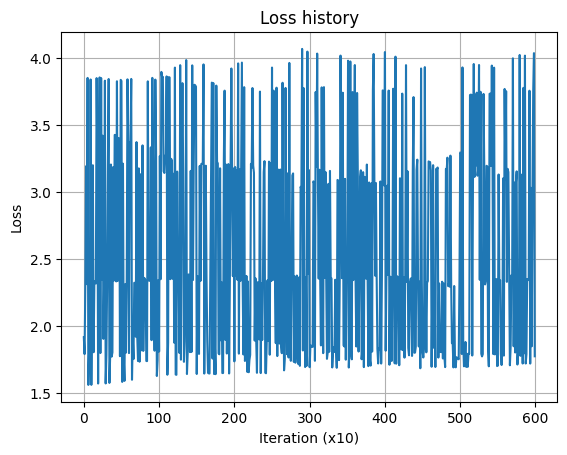

<Figure size 640x480 with 0 Axes>

In [15]:
# Training loop

def train(X_train, y_train, X_val, y_val, t_params, omega_params, learning_rate=0.002, epochs=1):
    loss_history = []
    for epoch in range(epochs):
        print("Epoch", epoch)
        for i in tqdm(range(len(X_train)), desc="Training"):
            x = X_train[i]
            y_true = y_train[i]
            t_params, omega_params, loss = minimize_step(x, y_true, t_params, omega_params, learning_rate)
            if i % 10 == 0:
                print("Loss:", loss)
                loss_history.append(loss)
        print("Validation accuracy:", model_accuracy(X_val, y_val, t_params, omega_params))
    return t_params, omega_params, loss_history

t_params, omega_params, loss_history = train(X_train, y_train, X_val, y_val, t_params, omega_params, learning_rate=0.002, epochs=1)
# In my case, using 10 cores, the training takes about 6 hour for one epoch

# Save the parameters

# Ensure the directory exists
modelparams_dir = os.path.join(script_dir, 'modelparams')
os.makedirs(modelparams_dir, exist_ok=True)

# Save the parameters
np.save(os.path.join(modelparams_dir, 't_params.npy'), t_params)
np.save(os.path.join(modelparams_dir, 'omega_params.npy'), omega_params)

# Plot the loss history
plt.plot(loss_history)
plt.xlabel("Iteration (x10)")
plt.ylabel("Loss")
plt.title("Loss history")
plt.grid()
plt.show()

# Save the plot
plt.savefig(os.path.join(modelparams_dir, "loss_history.png"))

In [16]:
# Load the parameters

t_params = np.load(os.path.join(modelparams_dir, 't_params.npy'))
omega_params = np.load(os.path.join(modelparams_dir, 'omega_params.npy'))

# Evaluate the model

print("Training accuracy:", model_accuracy(X_train, y_train, t_params, omega_params))
print("Validation accuracy:", model_accuracy(X_val, y_val, t_params, omega_params))

Training accuracy: 0.09316666666666666
Validation accuracy: 0.10666666666666667
